In [1]:
# pip install matplotlib
# pip install einops

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from scipy.stats import linregress, pearsonr
import itertools
import random

# Read in data 

In [2]:
dir = "/Users/rickiheicklen/Development/Github/scholars-and-sommeliers/"

In [3]:
def rename_columns(df_sources, df_wines):
    # Sources:
    # Abarbanel, Bartenura, Alfasi, Sforno, Rashi, Schwartz

    df_sources = df_sources.rename(columns={'Source 1': 'Abarbanel', 
                    'Source 2': 'Bartenura',
                    'Source 3': 'Alfasi',
                    'Source 4': 'Sforno',
                    'Source 5': 'Rashi',
                    'Source 6': 'Schwartz'})

    # Wines: 
    # Alfasi, Abarbanel, Bartenura, Rashi, Sforno, Schwartz

    df_wines = df_wines.rename(columns={'Wine A': 'Alfasi', 
                    'Wine B': 'Abarbanel',
                    'Wine C': 'Bartenura',
                    'Wine D': 'Rashi',
                    'Wine E': 'Sforno',
                    'Wine F': 'Schwartz'
                    })
    return(df_sources, df_wines)

def longify(sources_wide, wines_wide):
    df_sources_long = sources_wide.melt(id_vars=["Scholar"], var_name="Rishon", value_name="Source")
    df_wines_long = wines_wide.melt(id_vars=["Scholar"], var_name="Rishon", value_name="Wine")
    df_long = pd.merge(df_sources_long, df_wines_long, on=['Scholar', 'Rishon'])
    return df_long

def clean_data(file):
    df_orig = pd.read_csv(dir + file)
    source_cols = [x for x in df_orig.columns if 'Source' in x]
    wine_cols = [x for x in df_orig.columns if 'Wine' in x]

    df_sources = df_orig[['Scholar']+source_cols]
    df_wines = df_orig[['Scholar']+wine_cols]

    df_sources, df_wines = rename_columns(df_sources, df_wines)

    df_long = longify(df_sources, df_wines)

    # Originally imputed the mean to fill in the missing wines from Chana, but I think it's safer to just throw away the NaNs
    # df_imputed = pd.concat([group[group.columns[~group.columns.isin(numeric_cols)]].assign(**{col: imputer.fit_transform(group[[col]]) for col in numeric_cols}) for _, group in groups])

    df = df_long.dropna()

    return df

In [4]:
df = clean_data("data.csv")
df_fake = clean_data("fake_data.csv")

In [8]:
numeric_cols = ['Source', 'Wine'] # numeric_cols = df.select_dtypes(include='number').columns
name_cols = ['Scholar','Rishon']
# Group the data by the 'group' column
groups = df.groupby('Scholar')

# Set which variable to color the points by (either Scholar or Rishon)
factor = "Scholar"

In [124]:
# add scholar correlations
def add_reg(x,y, color): #colors, color_map):
    # Fit a linear regression model
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate the correlation coefficient
    r_corr = pearsonr(x, y)[0]

    # Calculate the R squared value
    r_squared = r_value ** 2

    # Plot the regression
    plt.plot(x, intercept + slope * x, linestyle='dashed',linewidth=1, color=color) # , color=colors, cmap=color_map)

def normalize_data(df, norm_factor):
    groups = df.groupby(norm_factor)
    df['source_normed'] = pd.concat([(group['Source'] - group['Source'].min())/(group['Source'].max() - group['Source'].min()) for _, group in groups])
    df['wine_normed'] = pd.concat([(group['Wine'] - group['Wine'].min())/(group['Wine'].max() - group['Wine'].min()) for _, group in groups])
    return df

def make_plot(df, s, w):

    # Make color map and labels
    colors, color_labels = pd.factorize(df[factor])
    color_labels = color_labels.tolist()
    color_map = cm.get_cmap('tab20')

    # Fit a linear regression model
    x = df[s]
    y = df[w]
    coefficients = np.polyfit(x, y, 1)
    polynomial = np.poly1d(coefficients)

    # Fit a linear regression model
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate the correlation coefficient
    r_corr = pearsonr(x, y)[0]

    # Calculate the R squared value
    r_squared = r_value ** 2

    # Create the scatterplot
    scatter = plt.scatter(x, y, c=colors, cmap=color_map, label="Data")

    # Plot the regression
    plt.plot(x, intercept + slope * x, 'r-')
    
    # Plot the scholar specific regressions
    for i in set(df[factor]):
        i_color = color_map(color_labels.index(i))
        add_reg(x = df[df[factor] == i][s], y = df[df[factor] == i][w], color = i_color) # colors=colors, color_map=color_map)

    # Add the correlation coefficient and R squared value to the plot
    plt.text(1.05, 0.15, f'Correlation coefficient: {r_corr:.3f}', transform=plt.gca().transAxes)
    plt.text(1.05, 0.1, f'R$^2$: {r_squared:.3f}', transform=plt.gca().transAxes)
    plt.text(1.05, 0.05, f'p-value: {p_value:.3f}', transform=plt.gca().transAxes)

    # Add the legend
    handles, _ = scatter.legend_elements()
    legend = plt.legend(handles=handles, labels=color_labels, bbox_to_anchor=(1.35, 1), title=factor)
    legend.get_title().set_weight('bold')

    # Add axes labels
    plt.xlabel('Source quality')
    plt.ylabel('Wine quality')

    # Add a title
    plt.title('Scholars and Sommeliers: Rishon Quality Plot')    


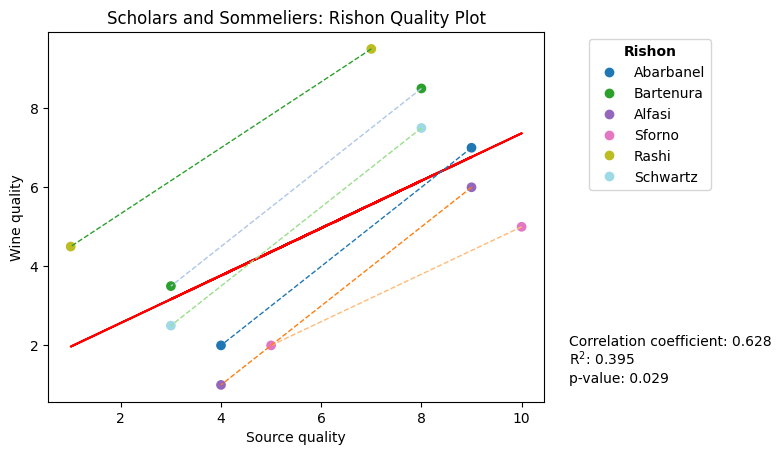

In [126]:
df_fake_normed = normalize_data(df_fake, factor)

make_plot(df_fake_normed, s = "Source", w = "Wine")

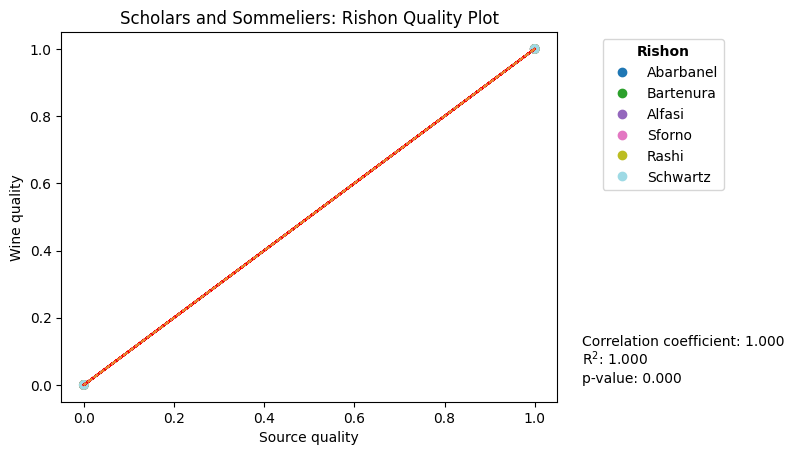

In [127]:
make_plot(df_fake_normed, s = "source_normed", w = "wine_normed")

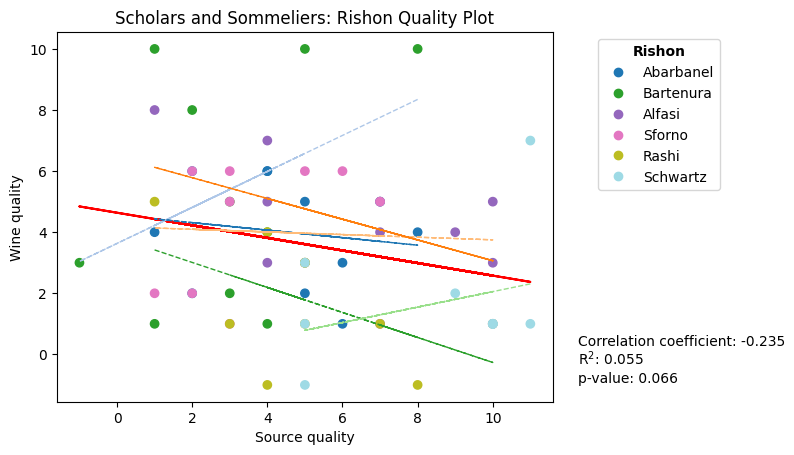

In [129]:
df_normed = normalize_data(df, norm_factor = factor)

make_plot(df_normed, s = "Source", w = "Wine")

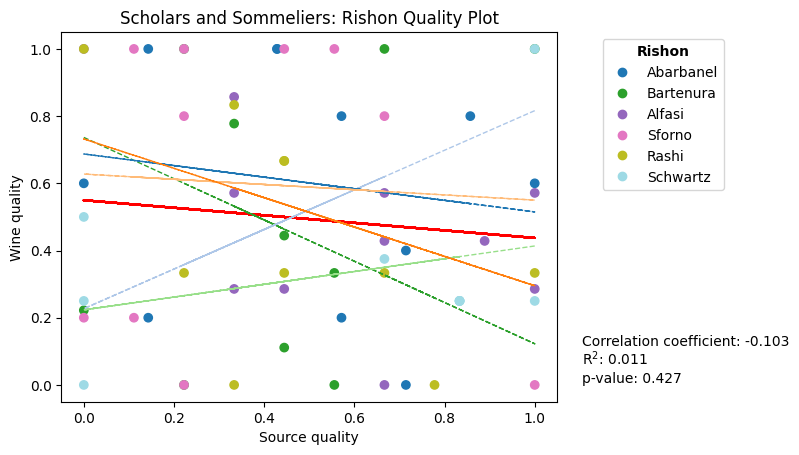

In [130]:
make_plot(df_normed, s = "source_normed", w = "wine_normed")

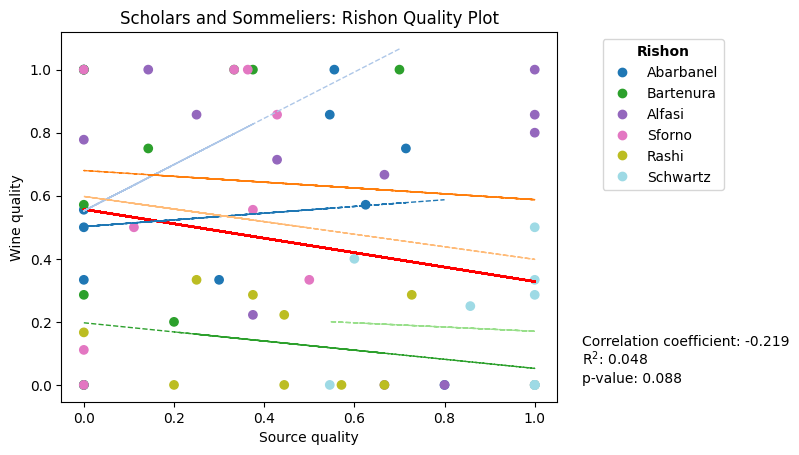

In [123]:
factor = "Rishon"

make_plot(df_normed, s = "source_normed", w = "wine_normed")

# Everything below this is scrap for now

In [74]:
# ### scrap code from auction problem ("splitting the pot")
# 
# # n = 50000
# dist = [0, 1, 5, 5, 5, 5, 5, 5, 8.3, 8.3, 8.3, 8.3, 8.3, 8.3, 10, 10, 10, 10, 10, 25] 
# applications = np.array(dist * round(n/len(dist)))
# random.shuffle(applications)
# application_groups = np.reshape(applications, (-1, 5))
#
# max([max([x*(50-sum(group)) for x in group]) for group in application_groups])

In [ ]:
# # Make color map and labels
# colors, color_labels = pd.factorize(df[factor])
# color_labels = color_labels.tolist()
# color_map = cm.get_cmap('tab20')

# # colors
# # color_labels
# # color_map

In [75]:
# ### Scrap from trying to use SimpleImputer ###

# # Create a SimpleImputer to impute missing values with the mean
# imputer = SimpleImputer(strategy='mean')
# # [group.columns[~group.columns.isin(numeric_cols)] for _, group in groups]
# for a, group in groups:
#     print(group) 


In [76]:
# for _, group in groups:
# #     min = group['Source'].min()
# #     max = group['Source'].max()
# #     print(group)
# #     # print(group['Wine'])
# #     print("min " + str(min))
# #     print("max " + str(max))
# #     print((group['Source'] - min)/(max-min))
# #     print("done")

# df['source_normed'] = pd.concat([(group['Source'] - group['Source'].min())/(group['Source'].max() - group['Source'].min()) for _, group in groups])
# df['wine_normed'] = pd.concat([(group['Wine'] - group['Wine'].min())/(group['Wine'].max() - group['Wine'].min()) for _, group in groups])

In [77]:
# s = "source_normed"
# w = "wine_normed"

# # Make color map and labels
# colors, color_labels = pd.factorize(df[factor])
# color_labels = color_labels.tolist()
# color_map = cm.get_cmap('tab20')

# # Fit a linear regression model
# x = df[s]
# y = df[w]
# coefficients = np.polyfit(x, y, 1)
# polynomial = np.poly1d(coefficients)

# # Fit a linear regression model
# slope, intercept, r_value, p_value, std_err = linregress(x, y)

# # Calculate the correlation coefficient
# r_corr = pearsonr(x, y)[0]

# # Calculate the R squared value
# r_squared = r_value ** 2

# # Create the scatterplot
# scatter = plt.scatter(x, y, c=colors, cmap=color_map, label="Data")

# # Plot the regression
# plt.plot(x, intercept + slope * x, 'r-')

# # Plot the scholar specific regressions
# add_reg(x = df[df['Scholar'] == "Ricki Heicklen"][s], y = df[df['Scholar'] == "Ricki Heicklen"][w])
# add_reg(x = df[df['Scholar'] == "Avital Morris"][s], y = df[df['Scholar'] == "Avital Morris"][w])


# # Add the correlation coefficient and R squared value to the plot
# plt.text(1.05, 0.15, f'Correlation coefficient: {r_corr:.3f}', transform=plt.gca().transAxes)
# plt.text(1.05, 0.1, f'R$^2$: {r_squared:.3f}', transform=plt.gca().transAxes)
# plt.text(1.05, 0.05, f'p-value: {p_value:.3f}', transform=plt.gca().transAxes)


# # Add the legend
# handles, _ = scatter.legend_elements()
# legend = plt.legend(handles=handles, labels=color_labels, bbox_to_anchor=(1.05, 1), title=factor)
# legend.get_title().set_weight('bold')

# # Add axes labels
# plt.xlabel('Source quality')
# plt.ylabel('Wine quality')

# # Add a title
# plt.title('Scholars and Sommeliers: Rishon Quality Plot')

In [78]:
# groups = df.groupby('Scholar')
# # pd.concat([group[group.columns[~group.columns.isin(numeric_cols)]].assign(**{col: group[[col]] for col in numeric_cols}) for _, group in groups])
# # [group[group.columns[~group.columns.isin(numeric_cols)]].assign(**{col: group[[col]] for col in numeric_cols}) for _, group in groups]

# for _, group in groups:
#     min = group['Source'].min()
#     max = group['Source'].max()
#     print(group)
#     # print(group['Wine'])
#     print("min " + str(min))
#     print("max " + str(max))
#     print((group['Source'] - min)/(max-min))
#     print("done")


In [79]:
# [group[group.columns[~group.columns.isin(numeric_cols)]] for _, group in groups]
# for a, group in groups:
#     print(group) 
#     for col in numeric_cols:
#         print(col)
#         print(imputer)
#         print(group[col])
#         # imputer.fit_transform(group[col].reshape(-1,1))


In [80]:
# [group[group.columns[~group.columns.isin(numeric_cols)]] for _, group in groups]


In [81]:
# mean_values = [group[col]]


In [82]:
### this is from one of Misha's interview problems, I have no idea why it's here but I don't want to delete it
# [0.5 * (1 + 2*i + np.sqrt(1 + 8*i*i)) for i in range(100)]

In [83]:
# from sklearn.impute import SimpleImputer
# import numpy as np

# # Create a 2D array with some missing values
# X = np.array([[1, 2, np.nan], [4, np.nan, 6], [7, 8, 9]])

# # Create a SimpleImputer instance with strategy='mean' and fit_transform the data
# imputer = SimpleImputer(strategy='mean')
# X_imputed = imputer.fit_transform(X)

# # Print the original and imputed data
# print("Original data:\n", X)
# print("Imputed data:\n", X_imputed)

# # imputer.fit_transform(np.array([[1,2,3,np.nan,3]])) #.toarray())

In [84]:
# import numpy as np
# from sklearn.impute import SimpleImputer
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp_mean.fit([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])

# X = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
# print(imp_mean.transform(X))


In [85]:
# from sklearn.impute import SimpleImputer
# import numpy as np

# # Create a 2D array with some missing values
# X = np.array([[1, 2, np.nan], [4, np.nan, 6], [7, 8, 9]])

# # Create a SimpleImputer instance with strategy='mean'
# imputer = SimpleImputer(strategy='mean')

# # Fit the imputer to the data
# imputer.fit(X)

# # Transform the data by filling in the missing values with the mean
# X_imputed = imputer.transform(X)

# # Print the original and imputed data
# print("Original data:\n", X)
# print("Imputed data:\n", X_imputed)

In [86]:
# imputer.fit_transform([[1,2,3,np.nan,3]]) #.toarray())


In [87]:
# df_imputed = pd.concat([group[group.columns[~group.columns.isin(numeric_cols)]].assign(**{col: imputer.fit_transform(group[[col]]) for col in numeric_cols}) for _, group in groups])

In [88]:
# df_imputed.head(60)

In [89]:
# Some code we are no longer using:
# 
# # # Create the scatter plot
# scatter = plt.scatter(df['score_source'], df['score_wine'], c=df['rishon_encoded'], cmap="viridis")

# # Add the color bar
# colorbar = plt.colorbar(scatter, label="Scholar")

# # Set the tick marks and labels on the color bar
# colorbar.set_ticks(range(len(Scholar_labels)))
# colorbar.set_ticklabels(Scholar_labels)


# plt.legend(handles=df["Scholar_encoded"], labels=Scholar_labels)

# # Add the color bar
# colorbar = plt.colorbar(scatter, cmap=color_map, label="Scholar",  extendfrac="auto", spacing="uniform", boundaries)
 
# # Set the tick marks and labels on the color bar
# colorbar.set_ticks(range(len(Scholar_labels)))
# colorbar.set_ticklabels(Scholar_labels)

In [90]:
# df = pd.read_csv("/Users/rickiheicklen/Github/scholars-and-sommeliers/data.csv")
# df_sources = df_orig[[x for x in df_orig.columns if 'Source' in x or 'Scholar' in x]]
# df_wines = df_orig[[x for x in df_orig.columns if 'Wine' in x or 'Scholar' in x]]
# df_sources['Type'] = "Source"
# df_wines['Type'] = "Wine"

In [91]:
# # Wines:
# # Abarbanel, Bartenura, Alfasi, Sforno, Rashi, Schwartz

# # Wines: 
# # Alfasi, Abarbanel, Bartenura, Rashi, Sforno, Schwartz

# df_orig.rename(columns={'Source 1': 'Abarbanel (Source)', 
#                    'Source 2': 'Bartenura (Source)',
#                    'Source 3': 'Alfasi (Source)',
#                    'Source 4': 'Sforno (Source)',
#                    'Source 5': 'Rashi (Source)',
#                    'Source 6': 'Schwartz (Source)',
#                    'Wine A': 'Alfasi (Wine)', 
#                    'Wine B': 'Abarbanel (Wine)',
#                    'Wine C': 'Bartenura (Wine)',
#                    'Wine D': 'Rashi (Wine)',
#                    'Wine E': 'Sforno (Wine)',
#                    'Wine F': 'Schwartz (Wine)'
#                    },
#                    inplace=True)

In [92]:
# df_orig
# df.melt(id_vars=["Scholar", "Type"], var_name="Rishon", value_name="score").head(60)

In [93]:
# df_sources_long = df_sources.melt(id_vars=["Scholar", "Type"], var_name="Rishon", value_name="score")
# df_wines_long = df_wines.melt(id_vars=["Scholar", "Type"], var_name="Rishon", value_name="score")

In [94]:
# pd.merge(df_sources_long, df_wines_long, on=['Scholar', 'Rishon'], suffixes=('_source', '_wine'))

In [95]:
# df.melt(id_vars=["Scholar", "Type"], var_name="Rishon", value_name="score").head(60)

In [96]:
# df = pd.read_csv("/Users/rickiheicklen/Github/scholars-and-sommeliers/data.csv")
# df_sources = df[[x for x in df.columns if 'Source' in x or 'Scholar' in x]]
# df_wines = df[[x for x in df.columns if 'Wine' in x or 'Scholar' in x]]
# df_sources['Type'] = "Source"
# df_wines['Type'] = "Wine"

In [97]:
# # Sources:
# # Abarbanel, Bartenura, Alfasi, Sforno, Rashi, Schwartz

# df_sources = df_sources.rename(columns={'Source 1': 'Abarbanel', 
#                    'Source 2': 'Bartenura',
#                    'Source 3': 'Alfasi',
#                    'Source 4': 'Sforno',
#                    'Source 5': 'Rashi',
#                    'Source 6': 'Schwartz'})

In [98]:
# # Wines: 
# # Alfasi, Abarbanel, Bartenura, Rashi, Sforno, Schwartz

# df_wines = df_wines.rename(columns={'Wine A': 'Alfasi', 
#                    'Wine B': 'Abarbanel',
#                    'Wine C': 'Bartenura',
#                    'Wine D': 'Rashi',
#                    'Wine E': 'Sforno',
#                    'Wine F': 'Schwartz'
#                    })
                

In [99]:
# df = pd.concat([df_sources, df_wines])

In [100]:
# def sources_and_wines(group):
#     sources = group[sources].values.tolist()
#     wines = group[wines].values.tolist()
#     return pd.Series({"Sources": sources, "Wines": wines})

# df_new = df.groupby("Scholar").apply(sources_and_wines).reset_index()

In [101]:
# # Wines:
# # Abarbanel, Bartenura, Alfasi, Sforno, Rashi, Schwartz

# # Wines: 
# # Alfasi, Abarbanel, Bartenura, Rashi, Sforno, Schwartz

# df.rename(columns={'Source 1': 'Abarbanel (Source)', 
#                    'Source 2': 'Bartenura (Source)',
#                    'Source 3': 'Alfasi (Source)',
#                    'Source 4': 'Sforno (Source)',
#                    'Source 5': 'Rashi (Source)',
#                    'Source 6': 'Schwartz (Source)',
#                    'Wine A': 'Alfasi (Wine)', 
#                    'Wine B': 'Abarbanel (Wine)',
#                    'Wine C': 'Bartenura (Wine)',
#                    'Wine D': 'Rashi (Wine)',
#                    'Wine E': 'Sforno (Wine)',
#                    'Wine F': 'Schwartz (Wine)'
#                    },
#                    inplace=True)

### scrap from ChatGPT

In [102]:
# import pandas as pd

# data = {
#     'Student': ['Alice', 'Bob', 'Charlie'],
#         'Color': ['red', 'yellow', 'blue'],
#     'Study Hours': [[0, 1, 2, 3], [4, 5, 6], [7, 8, 9, 10]],
#     'Test Scores': [[10, 20, 30, 40], [50, 60, 70], [80, 90, 100, 110]]
# }

# df = pd.DataFrame(data)
# df

In [103]:

# # Flatten the 'Study Hours' and 'Test Scores' columns
# df['Study Hours'] = df['Study Hours'].apply(lambda x: x[0])
# df['Test Scores'] = df['Test Scores'].apply(lambda x: x[0])

# # Create the scatter plot
# # plt.scatter(df['Study Hours'], df['Test Scores'], c=df['Student'])

In [104]:
# colors = ['red', 'blue', 'green']

# # Create the scatter plot
# plt.scatter(df['Study Hours'], df['Test Scores'], c=colors)


In [105]:
## Attempt at graphing rishonim

## Attempt at graphing rishonim

In [106]:
# df

In [107]:
# data = {
#     'Alice': [[0, 1, 2, 3], [10, 20, 30, 40]],
#     'Bob': [[4, 5, 6], [50, 60, 70]],
#     'Charlie': [[7, 8, 9, 10], [80, 90, 100, 110]]
# }

In [108]:
# data

In [109]:
# # Loop through the data and plot each student's data
# for student, (study_hours, test_scores) in data.items():
#     plt.scatter(study_hours, test_scores, label=student)

# # Add labels and title
# plt.xlabel('Study Hours')
# plt.ylabel('Test Scores')
# plt.title('Relationship between Study Hours and Test Scores')

# # Add a legend
# plt.legend()

# # Show the plot
# plt.show()

In [110]:
# # Loop through the data and plot each student's data
# for student, (study_hours, test_scores) in data.items():
#     plt.scatter(study_hours, test_scores, label=student)

# # Add labels and title
# plt.xlabel('Study Hours')
# plt.ylabel('Test Scores')
# plt.title('Relationship between Study Hours and Test Scores')

# # Add a legend
# plt.legend()

# # Show the plot
# plt.show()

In [111]:
# for index, row in df.iterrows():
#     plt.scatter(Source)
#     print(row['Scholar'], row['Abarbanel (Source)'])


In [112]:
# df = df.assign(Sources=lambda x: (x['Abarbanel (Source)'], x['Bartenura (Source)']))

In [113]:
# def sources_and_wines(group):
#     sources = group[sources].values.tolist()
#     wines = group[wines].values.tolist()
#     return pd.Series({"sources": sources, "wines": wines})

# df_new = df.groupby("Scholar").apply(scores_and_dates).reset_index()

In [114]:
# df.drop(tyoe)